iter:0, reward:-1057.078125
iter:200, reward:-530.044140625
iter:400, reward:-341.1296875
iter:600, reward:-265.665625
iter:800, reward:-253.8125
iter:1000, reward:-187.1125
iter:1200, reward:-212.14921875
iter:1400, reward:-222.971875
iter:1600, reward:-209.475
iter:1800, reward:-93.41875
iter:2000, reward:-105.85
iter:2200, reward:-102.5203125
iter:2400, reward:-78.45
iter:2600, reward:-83.9125
iter:2800, reward:-106.05
iter:3000, reward:-54.45
iter:3200, reward:-30.46875
iter:3400, reward:-48.15
iter:3600, reward:-45.09375
iter:3800, reward:-47.6625


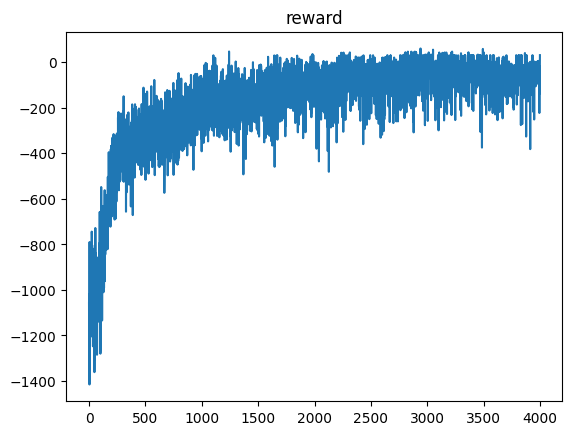

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from cc_ppo import PPO, PPOs
from cc_env import Charge_Env

# 设置环境参数
bus_num = 6
bus_vol = 35
bus_cost_step = 3
bus_cost_e = 0.2
charge_step = 2
charge_num = 3
min_e = 0.3
total_step = 48
price = Charge_Env.loadtxt("Data\price.txt")
people = Charge_Env.loadtxt("Data\people.txt")
p_wait = 1
e_r = 5
e_p = 0.5
free_e_p = 10
remain_p = 0.5

env = Charge_Env(
    bus_num,
    bus_vol,
    bus_cost_step,
    bus_cost_e,
    charge_step,
    charge_num,
    min_e,
    total_step,
    price,
    people,
    p_wait,
    e_r,
    e_p,
    free_e_p,
    remain_p,
)

# 设置智能体参数
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_episodes = 4000
gamma = 0.9
actor_lr = 1e-3
critic_lr = 1e-2
n_hiddens = 16
return_list = []
n_states = 12
n_actions = 3

agents = PPOs()
agents.set_same_params(
    bus_num,
    n_states=n_states,
    n_hiddens=n_hiddens,
    n_actions=n_actions,
    actor_lr=actor_lr,
    critic_lr=critic_lr,
    lmbda=0.95,
    epochs=10,
    eps=0.2,
    gamma=gamma,
    device=device,
)

for i in range(num_episodes):

    state = env.reset()
    done = False
    episode_return = 0

    dicts = PPOs.build_dicts(bus_num)

    while not done:
        actions = agents.take_action_same_state(state)

        next_state, reward, done = env.step(actions)
        dicts = PPOs.add_dicts(dicts, state, actions, next_state, reward, done)

        state = next_state
        episode_return += sum(reward)
    return_list.append(episode_return)
    agents.learn(dicts)
    if i % 200 == 0:
        print(f"iter:{i}, reward:{np.mean(return_list[-10:])}")


plt.plot(return_list)
plt.title("reward")
plt.show()

In [7]:
torch.save(agents,"model/model_03.pt")

In [8]:
import numpy as np
np.savetxt("Data/log_03.txt",np.array(return_list))